# Deformed Wing - Structural Modal Analysis

The following analysis shows the frequency of the structural modes for different wing tip deflections. The deformed shape has been obtained by running an aeroelastic simulation with the wing set at 1, 5 and 7 degrees angle of attack, density=1.225 kg/m3, no gravity and varying the velocity between 1 and 60m/s. Note these are __not__ aeroelastic modes, just the modal frequencies of the deformed structure.

Each of the text files available `sharpy_alpha0100_skin1/mode_00.txt` shows the mode number (sorted in ascending frequency) and whether the case is with or without skin. The first column in the data is the wing tip vertical displacement in metres in an inertial frame aligned with the flow and the second the modal frequencies in rad/s.

SHARPy discretisation:
  * Structural elements: twice the number of elements as the original UM/NAST discretisation. For each UM/NAST element SHARPy uses 2.
  * Chordwise panels: 16
  * Wake: horseshoe panel

Version Control:
  * SHARPy version: v1.1.1-234-g37298ed-37298ed
  * Pazy wing model version: 5036cbd0fca0765d2602a9bec8442e1c83c82212
  * Test script version: `pazy-sharpy/03a_DeformedModal` 6b8682261b83181edb1f47fb1ec4594632f0579a

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
%config InlineBackend.figure_format = 'retina'

In [2]:
results = []
for alpha in [1, 5, 7]:
    for skin in [True, False]:
        path = './sharpy_alpha{:04g}_skin{:g}/'.format(alpha * 100, skin)
        results.append({'data': [np.loadtxt(path + 'mode_{:02g}.txt'.format(i_mode)) for i_mode in range(5)],
                       'alpha': alpha,
                       'skin': skin})

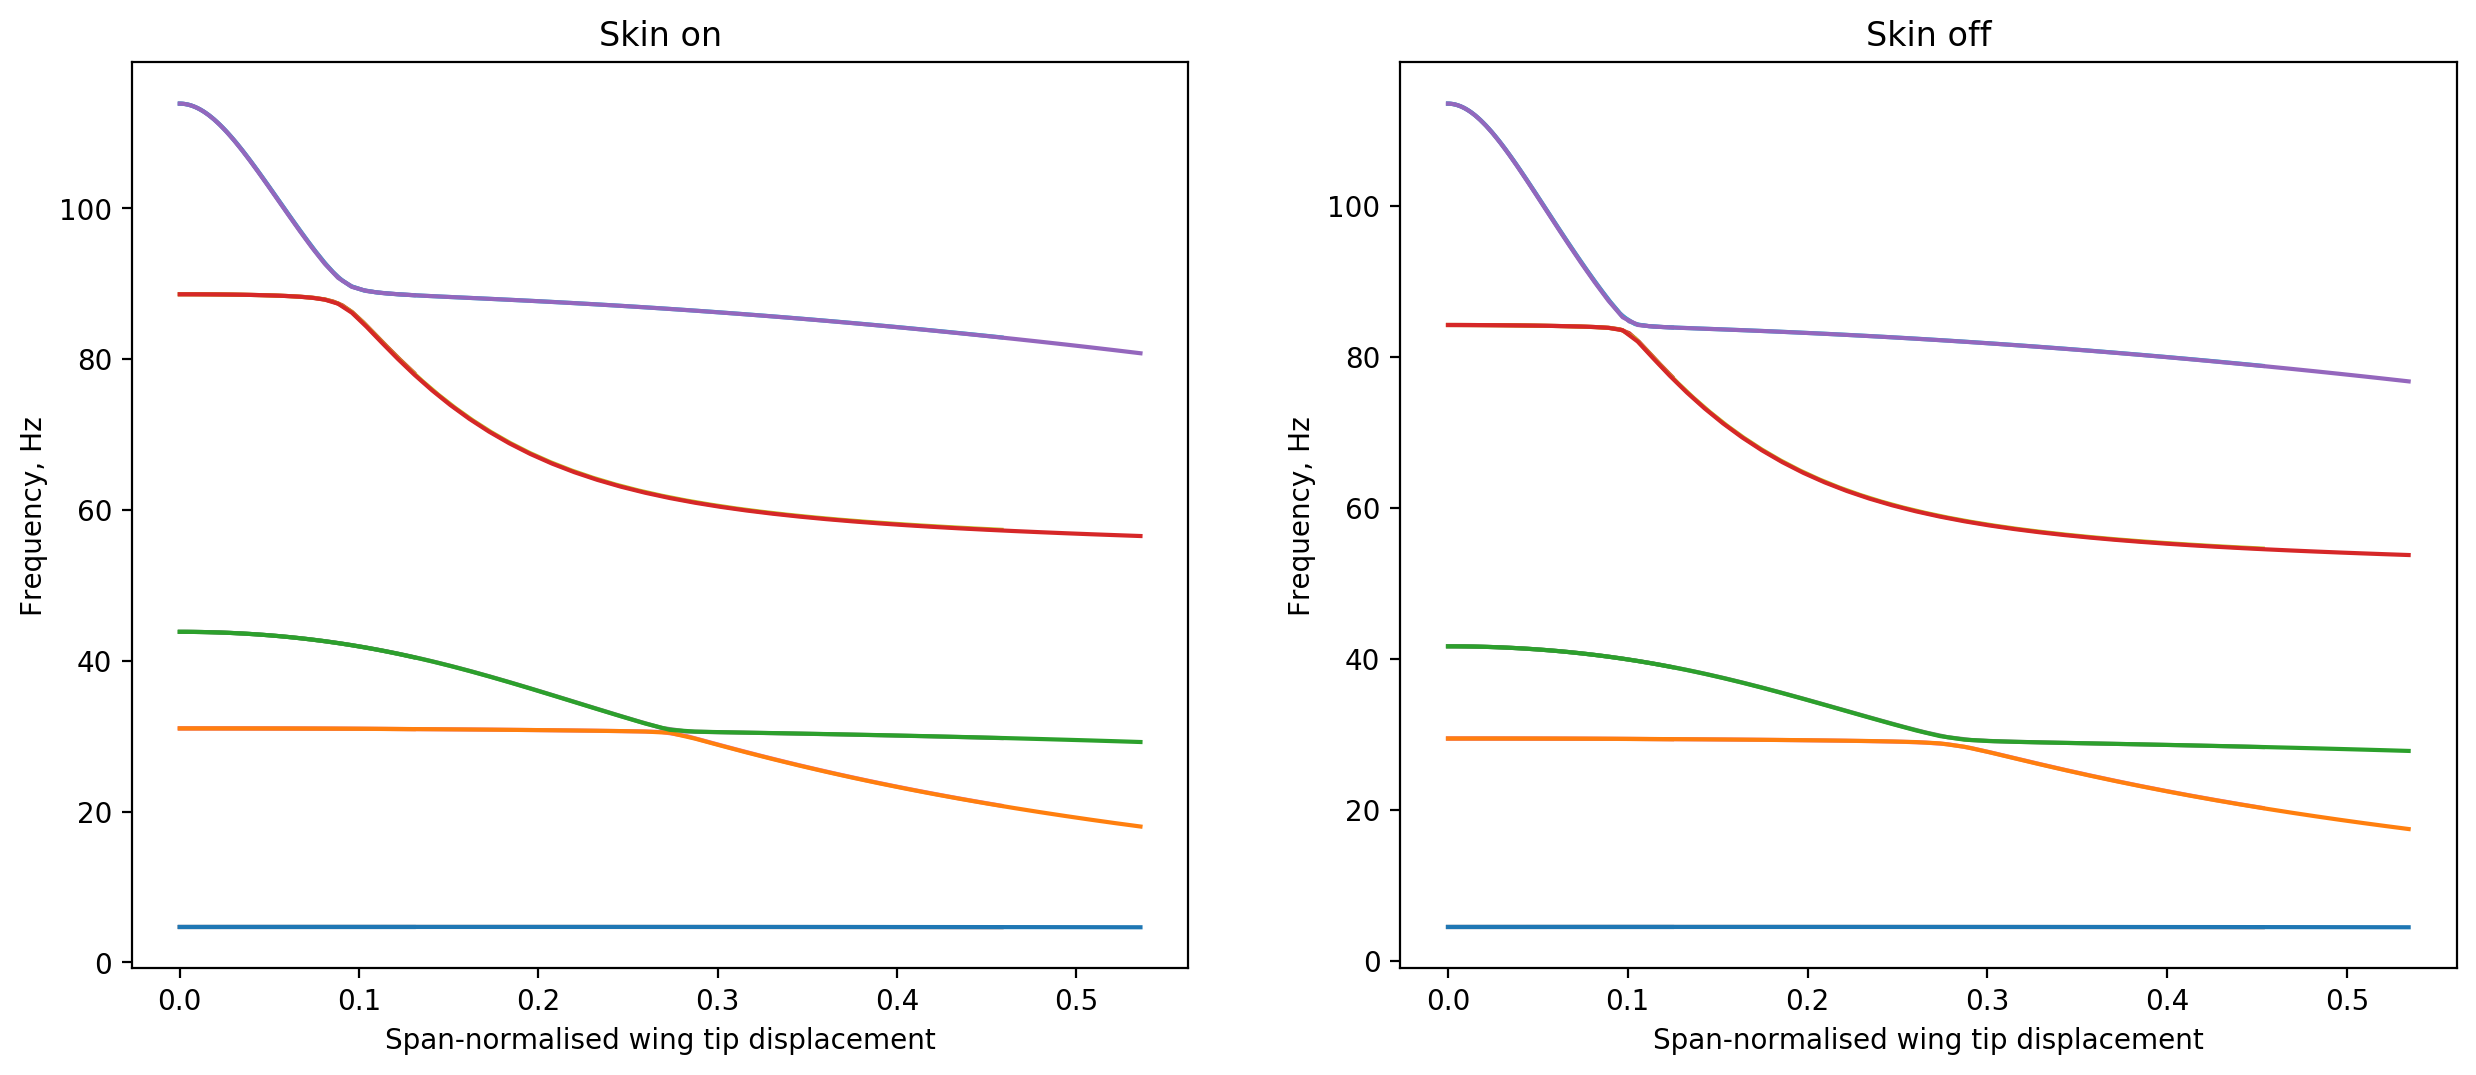

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

for case in results:
    for i_mode in range(5):
        if case['skin']:
            a = ax[0]
        else:
            a = ax[1]
            
        a.plot(case['data'][i_mode][:, 0] / 0.55, case['data'][i_mode][:, 1] / 2 / np.pi)
    
for a in ax:
    a.set_xlabel('Span-normalised wing tip displacement')
    a.set_ylabel('Frequency, Hz')
ax[0].set_title('Skin on')
ax[1].set_title('Skin off');